[View in Colaboratory](https://colab.research.google.com/github/rorycawley/DissertationCA2/blob/master/Rory_Final_Stacked_LSTM_100.ipynb)

**Resets the VM**

In [0]:
#!kill -9 -1

**Installs and environment detection**



In [2]:
!pip show tensorflow

Name: tensorflow
Version: 1.7.0
Summary: TensorFlow helps the tensors flow
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: grpcio, numpy, astor, gast, wheel, tensorboard, six, absl-py, protobuf, termcolor
Required-by: 


In [3]:
!pip show keras

Name: Keras
Version: 2.1.6
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, h5py, pyyaml, numpy, scipy
Required-by: 


In [4]:
!pip install wtte

  Found existing installation: six 1.11.0
    Uninstalling six-1.11.0:
      Successfully uninstalled six-1.11.0


In [5]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 2.0MB/s 


In [6]:
!uname -or

4.4.111+ GNU/Linux


In [7]:
!gcloud version

Google Cloud SDK 199.0.0
alpha 2017.09.15
beta 2017.09.15
bq 2.0.33
core 2018.04.20
gsutil 4.30


In [8]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True
  print(tf.test.gpu_device_name())

GPU device not found


In [9]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16479841342727699080]

In [10]:
!cat /proc/meminfo

MemTotal:       13341832 kB
MemFree:         1079328 kB
MemAvailable:   12656128 kB
Buffers:          132816 kB
Cached:         11096220 kB
SwapCached:            0 kB
Active:          1854712 kB
Inactive:        9716028 kB
Active(anon):     342076 kB
Inactive(anon):      280 kB
Active(file):    1512636 kB
Inactive(file):  9715748 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               924 kB
Writeback:             0 kB
AnonPages:        341728 kB
Mapped:           182772 kB
Shmem:               664 kB
Slab:             625448 kB
SReclaimable:     601832 kB
SUnreclaim:        23616 kB
KernelStack:        3056 kB
PageTables:         4320 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6670916 kB
Committed_AS:    1283924 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
HugePages_Total: 

In [11]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc eagerfpu pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm kaiser fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms xsaveopt
bugs		:
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache s

In [0]:
def connectWithGDrive():
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !apt-get update -qq 2>&1 > /dev/null
  !apt-get -y install -qq google-drive-ocamlfuse fuse
  from google.colab import auth
  auth.authenticate_user()
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()
  import getpass
  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
  return

# Comment this out if you're already able authed to load and save files
#connectWithGDrive()

#!mkdir -p drive
#!google-drive-ocamlfuse drive

**Import numpy and pandas (to work with the csv file) and matplotlib for visualisation**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
PYTHONHASHSEED = 0

**Set column names for the training and test data**

In [14]:
id_col = 'unit_number'
time_col = 'time'
feature_cols = [ 'op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_measurement_{}'.format(x) for x in range(1,22)]
column_names = [id_col, time_col] + feature_cols
column_names

['unit_number',
 'time',
 'op_setting_1',
 'op_setting_2',
 'op_setting_3',
 'sensor_measurement_1',
 'sensor_measurement_2',
 'sensor_measurement_3',
 'sensor_measurement_4',
 'sensor_measurement_5',
 'sensor_measurement_6',
 'sensor_measurement_7',
 'sensor_measurement_8',
 'sensor_measurement_9',
 'sensor_measurement_10',
 'sensor_measurement_11',
 'sensor_measurement_12',
 'sensor_measurement_13',
 'sensor_measurement_14',
 'sensor_measurement_15',
 'sensor_measurement_16',
 'sensor_measurement_17',
 'sensor_measurement_18',
 'sensor_measurement_19',
 'sensor_measurement_20',
 'sensor_measurement_21']

**Use pandas to read in the csv files**

In [0]:
# read training data
#train_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/train.csv', header=None, names=column_names, index_col=['unit_number', 'time'])
train_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/train.csv', header=None, names=column_names)


# read test data
#test_x_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_x.csv', header=None, names=column_names, index_col=['unit_number', 'time'])
test_x_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_x.csv', header=None, names=column_names)


# read ground truth data
test_y_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_y.csv', header=None, names=['T'])

In [16]:
# Change the index to be Engine and Cycle Time
train_orig.set_index(['unit_number', 'time'], verify_integrity=True)
test_x_orig.set_index(['unit_number', 'time'], verify_integrity=True)

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1           0.0023        0.0003         100.0   
            2          -0.0027       -0.0003         100.0   
            3           0.0003        0.0001         100.0   
            4           0.0042        0.0000         100.0   
            5           0.0014        0.0000         100.0   
            6           0.0012        0.0003         100.0   
            7          -0.0000        0.0002         100.0   
            8           0.0006       -0.0000         100.0   
            9          -0.0036        0.0000         100.0   
            10         -0.0025       -0.0001         100.0   
            11          0.0007       -0.0004         100.0   
            12          0.0026        0.0003         100.0   
            13         -0.0056        0.0003         100.0   
            14          0.0017       -0.0004         100.0   
            15         -0.0003       -0.0003         100.0   
            16         -0.0018        0.0003         100.0   
            17          0.0014        0.0002         100.0   
            18          0.0035        0.0001         100.0   
            19          0.0029        0.0001         100.0   
            20          0.0011       -0.0001         100.0   
            21          0.0038       -0.0002         100.0   
            22          0.0012        0.0001         100.0   
            23          0.0009       -0.0000         100.0   
            24         -0.0006       -0.0001         100.0   
            25          0.0028       -0.0003         100.0   
            26          0.0047       -0.0005         100.0   
            27         -0.0007        0.0001         100.0   
            28          0.0022        0.0005         100.0   
            29          0.0014        0.0001         100.0   
            30         -0.0025        0.0004         100.0   
...                        ...           ...           ...   
100         169         0.0026       -0.0000         100.0   
            170        -0.0006       -0.0004         100.0   
            171        -0.0026       -0.0003         100.0   
            172         0.0007        0.0003         100.0   
            173        -0.0003       -0.0000         100.0   
            174        -0.0005        0.0003         100.0   
            175         0.0019        0.0000         100.0   
            176         0.0002        0.0002         100.0   
            177        -0.0041       -0.0003         100.0   
            178         0.0001        0.0005         100.0   
            179         0.0041        0.0001         100.0   
            180        -0.0004        0.0001         100.0   
            181        -0.0010        0.0000         100.0   
            182        -0.0027       -0.0001         100.0   
            183         0.0009        0.0001         100.0   
            184         0.0001       -0.0004         100.0   
            185         0.0032        0.0004         100.0   
            186        -0.0025        0.0005         100.0   
            187         0.0019        0.0002         100.0   
            188         0.0010        0.0005         100.0   
            189        -0.0003        0.0002         100.0   
            190        -0.0038        0.0002         100.0   
            191        -0.0031       -0.0001         100.0   
            192        -0.0034        0.0001         100.0   
            193         0.0018        0.0004         100.0   
            194         0.0049        0.0000         100.0   
            195        -0.0011       -0.0001         100.0   
            196        -0.0006       -0.0003         100.0   
            197        -0.0038        0.0001         100.0   
            198         0.0013        0.0003         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                               

In [17]:
train_orig.head()

,unit_number,time,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [18]:
test_y_orig.head()

,T
0,112
1,98
2,69
3,82
4,91


In [19]:
train_orig.shape

(20631, 26)

In [20]:
test_x_orig.shape

(13096, 26)

In [21]:
test_y_orig.shape

(100, 1)

**Take a look a some data**

In [0]:
# Take engine 3 from the list of 100 engine sequences
engine_id3 = train_orig.loc[train_orig['unit_number'] == 3]

# Select the final 50 cycles of that engine's life before it fails
engine_id3_50cycleWindow = engine_id3.tail(50)

sensor_cols = [  'sensor_measurement_1',
                 'sensor_measurement_2',
                 'sensor_measurement_3',
                 'sensor_measurement_4',
                 'sensor_measurement_5',
                 'sensor_measurement_6',
                 'sensor_measurement_7',
                 'sensor_measurement_8',
                 'sensor_measurement_9',
                 'sensor_measurement_10',
                 'sensor_measurement_11',
                 'sensor_measurement_12',
                 'sensor_measurement_13',
                 'sensor_measurement_14',
                 'sensor_measurement_15',
                 'sensor_measurement_16',
                 'sensor_measurement_17',
                 'sensor_measurement_18',
                 'sensor_measurement_19',
                 'sensor_measurement_20',
                 'sensor_measurement_21']
# Select only the dynamic sensor readings
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[sensor_cols]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
#ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

**Now we scale the data so it's all the same range and it can be processed by the neural network**

In [0]:
from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Combine the X values to normalize them
all_data_orig = pd.concat([train_orig, test_x_orig])

# Use a scale -1 to 1 since that matches our tanh activation function range
scaler = pipeline.Pipeline(steps=[
     ('minmax', MinMaxScaler(feature_range=(-1, 1))),
     ('remove_constant', VarianceThreshold())
])

all_data = all_data_orig.copy()
all_data = np.concatenate([all_data[['unit_number', 'time']], scaler.fit_transform(all_data[feature_cols])], axis=1)


# then split them back out
train = all_data[0:train_orig.shape[0], :]
test = all_data[train_orig.shape[0]:, :]

# Make engine numbers and days zero-indexed, for everybody's sanity
train[:, 0:2] -= 1
test[:, 0:2] -= 1

In [0]:
#df = pd.DataFrame(train)
#df

**Build the data to be processed by the RNN, must be of the format *(batch_size, timesteps, input_features)* instead of *(timesteps, input_features)*  **

In [0]:
import tqdm
from tqdm import tqdm
def build_data(engine, time, x, max_time, is_test, mask_value):
    # y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
    out_y = []
    
    # number of features
    d = x.shape[1]

    # A full history of sensor readings to date for each x
    out_x = []

    # Get the unique number of enginges
    n_engines= np.unique(train[:, 0]).size
    
    for i in tqdm(range(n_engines)):
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
      
        # This gets the highest cycle time for an engine, this is the failure time for training data
        # but not for the test data
        max_engine_time = int(np.max(time[engine == i])) + 1
        #print("Engine " + str(i) + " has max_engine_time " + str(max_engine_time))
        
        # The
        if is_test:
            start = max_engine_time - 1
        else:
            start = 0

        this_x = []

        for j in range(start, max_engine_time):
            # This gets all of the sensor values for the engine i
            engine_x = x[engine == i]

            # This adds the final cycle time to the list
            out_y.append(np.array((max_engine_time - j, 1), ndmin=2))

            xtemp = np.zeros((1, max_time, d))
            xtemp += mask_value
            
            xtemp[:, max_time-min(j, 99)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]
            this_x.append(xtemp)
            

            
        this_x = np.concatenate(this_x)
        out_x.append(this_x)
    out_x = np.concatenate(out_x)
    out_y = np.concatenate(out_y)
    return out_x, out_y

In [26]:
# This is the current format of the data (timesteps, input_features)
train.shape

(20631, 19)

In [27]:
# # Configurable observation look-back period for each engine/day
max_time = 100
mask_value = -99

# Build the training data 
train_x, train_y = build_data( engine = train[:, 0], time = train[:, 1], x = train[:, 2:], max_time = max_time, is_test = False, mask_value = mask_value)

# Build the test data 
test_x,_ = build_data(engine=test[:, 0], time=test[:, 1], x=test[:, 2:], max_time=max_time, is_test=True, mask_value=mask_value)

# always observed in our case
test_y = test_y_orig.copy()
test_y['E'] = 1

100%|██████████| 100/100 [00:00<00:00, 7057.32it/s]


In [28]:
train_y[:,0]

array([192, 191, 190, ...,   3,   2,   1])

In [29]:
# this is the new format (batch_size, timesteps, input_features)
train_x.shape

(20631, 100, 17)

In [30]:
train_y.shape

(20631, 2)

In [31]:
test_x.shape

(100, 100, 17)

**Initialise the values for the model**

In [32]:
tte_mean_train = np.nanmean(train_y[:,0])
mean_u = np.nanmean(train_y[:,1])

# Initialization value for alpha-bias 
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u
print('tte_mean_train', tte_mean_train, 'init_alpha: ',init_alpha,'mean uncensored train: ',mean_u)

tte_mean_train 108.80786195530997 init_alpha:  109.30709957832491 mean uncensored train:  1.0


**Start building the model**

In [33]:
import keras.backend as K
from keras.callbacks import History, TerminateOnNaN
from wtte.wtte import WeightWatcher


K.set_epsilon(1e-10)
print('epsilon', K.epsilon())

history = History()
weightwatcher = WeightWatcher()
nanterminator = TerminateOnNaN()

epsilon 1e-10


Using TensorFlow backend.


In [0]:
#saved_model_file = "drive/Colab Notebooks/modelTemplate.json"
saved_model_weights = "drive/Colab Notebooks/model_weightsTemplate.h5"
saved_model_history = "drive/Colab Notebooks/model_historyTemplate.json"

In [0]:
import wtte.wtte as wtte

#from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Masking, Lambda
from keras.optimizers import RMSprop,adam


n_features = train_x.shape[-1]

model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))
model.add(GRU(100, activation='tanh', recurrent_dropout=0.25, return_sequences=True))
model.add(GRU(100, activation='tanh', recurrent_dropout=0.25, return_sequences=True))
model.add(GRU(100, activation='tanh', recurrent_dropout=0.25))

model.add(Dense(10,activation='tanh'))

# We need 2 neurons to output Alpha and Beta parameters for our Weibull distribution
model.add(Dense(2))

model.add(Lambda(wtte.output_lambda, 
                 arguments={"init_alpha":init_alpha, 
                            "max_beta_value":100.0, 
                            "alpha_kernel_scalefactor":0.5
                           },
                ))

# Use the discrete log-likelihood for Weibull survival data as our loss function
loss = wtte.loss(kind='discrete',reduce_loss=False).loss_function

model.compile(loss=loss, optimizer=adam(lr=.01, clipvalue=0.5))
#model.compile(loss=loss, optimizer=RMSprop(lr=0.01))

**Train the model to the data**

In [90]:
import time
start = time.time()
load_weights_from_file = False

if load_weights_from_file:
  #print("Recreating a previously saved the model from files")
  
  # Issue in Keras with doing this
  # Model reconstruction from JSON file
  #with open(saved_model_file, 'r') as f:
  #  model = model_from_json(f.read())

  # Load weights into the new model
  print("Loading weights from file")
  model.load_weights(saved_model_weights)
else: 
  model.fit(train_x, train_y,
              epochs=10,
              batch_size=100, 
              verbose=1,
              validation_data=(test_x, test_y),
              callbacks=[nanterminator,history,weightwatcher])
  
end = time.time()
print(end - start)

Train on 20631 samples, validate on 100 samples
Epoch 1/10
  200/20631 [..............................] - ETA: 6:40 - loss: -inf   Batch 1: Invalid loss, terminating training
6.29891037940979


/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:337: RuntimeWarning: invalid value encountered in multiply
  self._values[k][0] += v * (current - self._seen_so_far)
/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:337: RuntimeWarning: invalid value encountered in double_scalars
  self._values[k][0] += v * (current - self._seen_so_far)


In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, None, 17)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 100)         47200     
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
_________________________________________________________________
lambda_2 (Lambda)            (None, 2)                 0         
Total para

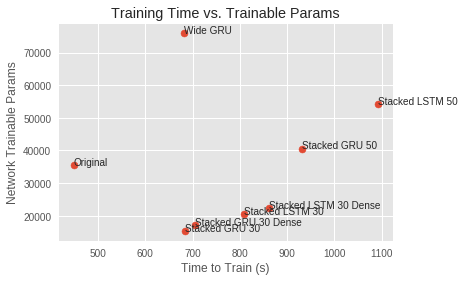

In [45]:
import matplotlib
matplotlib.style.use('ggplot')

# This is a plot to show the training time vs the number of trainable params in the model
models_names = ('Original', 'Wide GRU', 'Stacked GRU 30', 'Stacked GRU 50', 'Stacked LSTM 30','Stacked LSTM 50','Stacked GRU 30 Dense', 'Stacked LSTM 30 Dense')
time =   [448,  682,  684, 931, 809, 1092, 704, 861]
params = [35602,75902,15362, 40602, 20462, 54102, 17222,22322]

fig, ax = plt.subplots()
ax.scatter(time, params)


for i, txt in enumerate(models_names):
    ax.annotate(txt, (time[i],params[i]))
plt.xlabel('Time to Train (s)')
plt.ylabel('Network Trainable Params')
plt.title('Training Time vs. Trainable Params')
plt.grid(True)
plt.show()

**Save the model and weights to files**

In [0]:
#import pickle

# there's an issue with keras saving custom layers
#model_json = model.to_json()
#with open("drive/Colab Notebooks/modelTemplate.json", "w") as json_file:
#    json_file.write(model_json)
#    print("Saved model to drive")

# serialize weights to HDF5
#model.save_weights(saved_model_weights)
#print("Saved weights to drive")

#with open(saved_model_history, 'wb') as file_pi:
#    pickle.dump(history.history, file_pi)
#    print("Saved history to drive")


**Show results of the training**

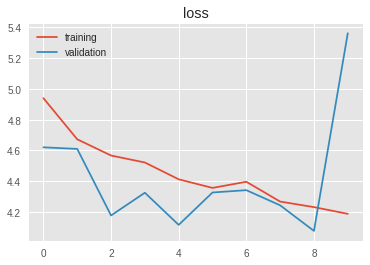

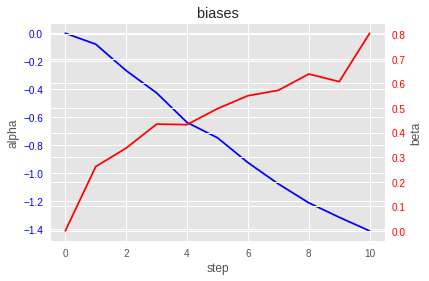

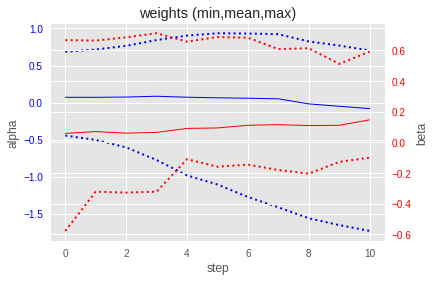

In [46]:
plt.plot(history.history['loss'],    label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.title('loss')
plt.legend()

weightwatcher.plot()

**Use the model to make predictions**

In [0]:
# Make some predictions and put them alongside the real TTE and event indicator values
test_predict = model.predict(test_x)
test_predict = np.resize(test_predict, (100, 2))
test_result = np.concatenate((test_y, test_predict), axis=1)

**Show the accuracy of the prediction by comparing the mode of the distribution with the true value**

In [48]:
# This is the true value
test_y

,T,E
0,112,1
1,98,1
2,69,1
3,82,1
4,91,1
5,93,1
6,91,1
7,95,1
8,111,1
9,96,1


In [49]:
# this is the predicted alpha and beta defining the curve for the distribution
test_predict.shape

(100, 2)

In [50]:
test_predict

array([[192.69951  ,   6.1854935],
       [185.59267  ,   6.3470483],
       [ 61.985943 ,   7.976414 ],
       [ 70.13164  ,   8.077738 ],
       [101.28623  ,   7.9468436],
       [100.44652  ,   8.042427 ],
       [126.96121  ,   7.633939 ],
       [ 69.80682  ,   8.065826 ],
       [141.51865  ,   6.9819784],
       [ 96.86149  ,   8.100719 ],
       [120.496414 ,   7.5542307],
       [ 75.33718  ,   8.1041355],
       [ 65.63956  ,   8.030503 ],
       [158.53705  ,   6.880849 ],
       [101.4966   ,   8.065137 ],
       [ 88.118706 ,   8.052896 ],
       [ 50.815956 ,   7.84249  ],
       [ 45.989697 ,   7.679715 ],
       [ 78.26334  ,   8.032235 ],
       [ 13.151479 ,   5.0358615],
       [ 78.38579  ,   8.022945 ],
       [193.21863  ,   6.157563 ],
       [145.37343  ,   7.2561502],
       [ 20.978722 ,   6.6060104],
       [151.91864  ,   7.088129 ],
       [152.53183  ,   7.045825 ],
       [ 85.38641  ,   8.147669 ],
       [ 84.55907  ,   8.101341 ],
       [ 87.50185  ,

In [51]:
test_result.shape

(100, 4)

In [52]:
test_result

array([[112.        ,   1.        , 192.69950867,   6.18549347],
       [ 98.        ,   1.        , 185.59266663,   6.34704828],
       [ 69.        ,   1.        ,  61.98594284,   7.9764142 ],
       [ 82.        ,   1.        ,  70.13163757,   8.07773781],
       [ 91.        ,   1.        , 101.28623199,   7.94684362],
       [ 93.        ,   1.        , 100.44651794,   8.04242706],
       [ 91.        ,   1.        , 126.96121216,   7.63393879],
       [ 95.        ,   1.        ,  69.80682373,   8.06582642],
       [111.        ,   1.        , 141.51864624,   6.98197842],
       [ 96.        ,   1.        ,  96.86148834,   8.10071945],
       [ 97.        ,   1.        , 120.49641418,   7.55423069],
       [124.        ,   1.        ,  75.33718109,   8.10413551],
       [ 95.        ,   1.        ,  65.63955688,   8.03050327],
       [107.        ,   1.        , 158.53704834,   6.88084888],
       [ 83.        ,   1.        , 101.49659729,   8.06513691],
       [ 84.        ,   1

In [53]:
theTruth = test_y['T'].tolist()
theTruth

[112,
 98,
 69,
 82,
 91,
 93,
 91,
 95,
 111,
 96,
 97,
 124,
 95,
 107,
 83,
 84,
 50,
 28,
 87,
 16,
 57,
 111,
 113,
 20,
 145,
 119,
 66,
 97,
 90,
 115,
 8,
 48,
 106,
 7,
 11,
 19,
 21,
 50,
 142,
 28,
 18,
 10,
 59,
 109,
 114,
 47,
 135,
 92,
 21,
 79,
 114,
 29,
 26,
 97,
 137,
 15,
 103,
 37,
 114,
 100,
 21,
 54,
 72,
 28,
 128,
 14,
 77,
 8,
 121,
 94,
 118,
 50,
 131,
 126,
 113,
 10,
 34,
 107,
 63,
 90,
 8,
 9,
 137,
 58,
 118,
 89,
 116,
 115,
 136,
 28,
 38,
 20,
 85,
 55,
 128,
 137,
 82,
 59,
 117,
 20]

In [54]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)
  
def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)
  
def weibull_mode(alpha, beta):
    assert np.all(beta > 1)
    return alpha * ((beta-1)/beta)**(1/beta)
test_results_df = pd.DataFrame(test_result, columns=['T', 'E', 'alpha', 'beta'])

test_results_df['T'].describe()


count    100.00000
mean      75.52000
std       41.76497
min        7.00000
25%       32.75000
50%       86.00000
75%      112.25000
max      145.00000
Name: T, dtype: float64

In [0]:

test_results_df['predicted_mode'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)
predictedModeValues = test_results_df['predicted_mode'].tolist()

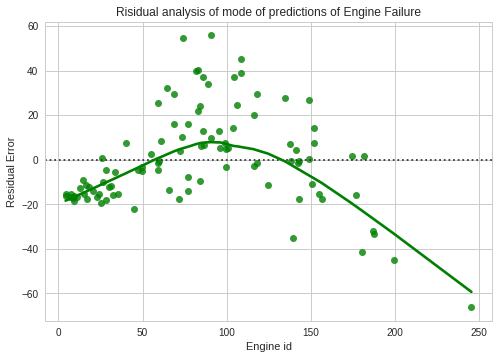

In [56]:
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

# List of data
prediced_list = predictedModeValues # [10, 20, 10, 50, 30, 40, 40, 33, 49, 10, 10, 50, 30, 40, 40, 10, 20, 10, 50, 30, 40, 40, 33, 49, 10, 10 ]
truth_list =  theTruth #  [13, 18, 13, 40, 33, 42, 41, 30, 30, 40, 13, 15, 13, 40, 20, 13, 40, 33, 49, 10, 50, 30, 40, 13, 15, 13 ]
predictions = np.array(prediced_list)
test = np.array(truth_list)

# Plot the residuals after fitting a linear model
r_ax = sns.residplot(predictions, test, lowess=True, color="g")
r_ax.set(ylabel='Residual Error', xlabel='Engine id')
plt.title('Risidual analysis of mode of predictions of Engine Failure')

plt.show()

In [57]:
# To compare the different models I use RMSE
# http://hamelg.blogspot.ie/2015/11/python-for-data-analysis-part-27-linear.html
# Root mean squared error (RMSE) is a common evaluation metric for predictions 
# involving real numbers. Root mean squared error is square root of the average of the squared error (residuals.). 

from sklearn.metrics import mean_squared_error

def rmse(predicted, targets):
    """
    Computes root mean squared error of two numpy ndarrays
    
    Args:
        predicted: an ndarray of predictions
        targets: an ndarray of target values
    
    Returns:
        The root mean squared error as a float
    """
    # use the scikit-learn library's mean squared error function and take the square root of the result
    return mean_squared_error(predicted, targets)**0.5

rmse(predictions, test)

29.32871002997126

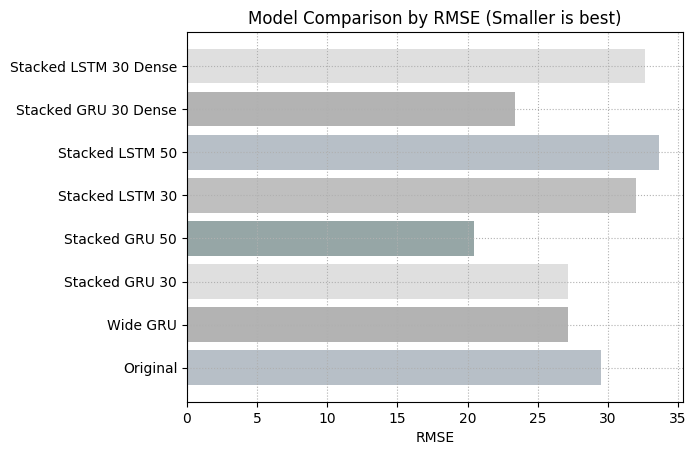

In [58]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')

 
colors = ['#708090', '#696969', '#C0C0C0', '#2F4F4F', '#808080']

objects = ('Original', 'Wide GRU', 'Stacked GRU 30', 'Stacked GRU 50', 'Stacked LSTM 30', 'Stacked LSTM 50', 'Stacked GRU 30 Dense', 'Stacked LSTM 30 Dense')
y_pos = np.arange(len(objects))
performance = [ 29.53, 27.12, 27.18, 20.43, 32, 33.66, 23.34, 32.65 ]
 
plt.barh(y_pos, performance, align='center', alpha=0.5,color=colors)
plt.yticks(y_pos, objects)
plt.xlabel('RMSE')
plt.title('Model Comparison by RMSE (Smaller is best)')
plt.grid(linestyle='dotted')

plt.show()

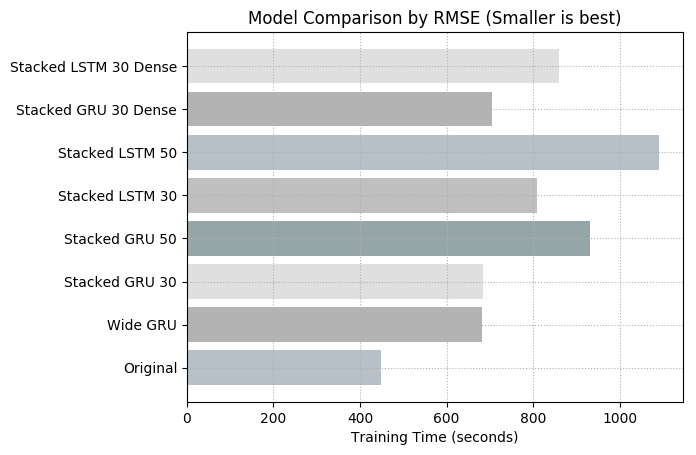

In [59]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')

colors = ['#708090', '#696969', '#C0C0C0', '#2F4F4F', '#808080']


# This is a plot to show the training time vs the number of trainable params in the model
objects = ('Original', 'Wide GRU', 'Stacked GRU 30', 'Stacked GRU 50', 'Stacked LSTM 30','Stacked LSTM 50','Stacked GRU 30 Dense', 'Stacked LSTM 30 Dense')
y_pos = np.arange(len(objects))
time =   [448,  682,  684, 931, 809, 1092, 704, 861]

plt.barh(y_pos, time, align='center', alpha=0.5,color=colors)
plt.yticks(y_pos, objects)
plt.xlabel('Training Time (seconds)')
plt.title('Model Comparison by RMSE (Smaller is best)')
plt.grid(linestyle='dotted')

plt.show()

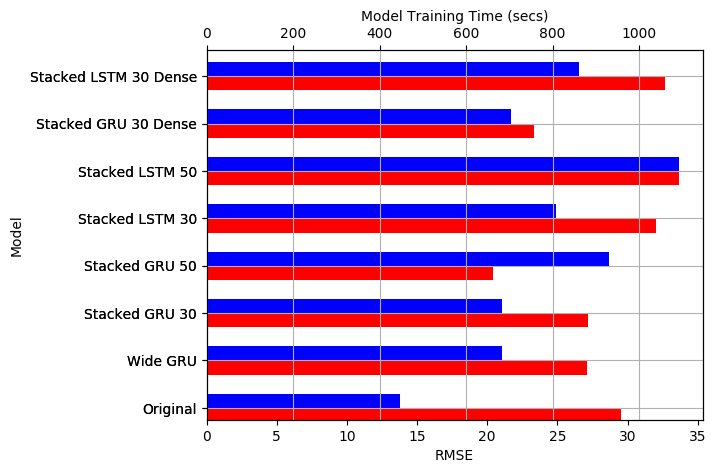

In [60]:
objects = ('Original', 'Wide GRU', 'Stacked GRU 30', 'Stacked GRU 50', 'Stacked LSTM 30','Stacked LSTM 50','Stacked GRU 30 Dense', 'Stacked LSTM 30 Dense')
performance = [ 29.53, 27.12, 27.18, 20.43, 32, 33.66, 23.34, 32.65 ]
time =   [448,  682,  684, 931, 809, 1092, 704, 861]

dfGraph = pd.DataFrame(list(map(list, zip(objects,performance,time))))

dfGraph = pd.DataFrame(list(zip(objects,performance,time)),
              columns=['Title','RMSE', 'Time'])
#dfGraph

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twiny() # Create another axes that shares the same x-axis as ax.

width = 0.3

dfGraph.RMSE.plot(kind='barh', color='red', ax=ax, width=width, position=1)
dfGraph.Time.plot(kind='barh', color='blue', ax=ax2, width=width, position=0)
ax.set_yticklabels(dfGraph.Title)


ax.set_ylabel('Model')
ax.set_xlabel('RMSE')
ax2.set_xlabel('Model Training Time (secs)')
plt.grid(True)
plt.show()

In [0]:
test_results_df['unit_number'] = np.arange(1, test_results_df.shape[0]+1)

In [62]:
test_results_df

,T,E,alpha,beta,predicted_mode,unit_number
0,112.0,1.0,192.699509,6.185493,187.283423,1
1,98.0,1.0,185.592667,6.347048,180.646577,2
2,69.0,1.0,61.985943,7.976414,60.953659,3
3,82.0,1.0,70.131638,8.077738,68.993569,4
4,91.0,1.0,101.286232,7.946844,99.586550,5
5,93.0,1.0,100.446518,8.042427,98.801791,6
6,91.0,1.0,126.961212,7.633939,124.647454,7
7,95.0,1.0,69.806824,8.065826,68.670591,8
8,111.0,1.0,141.518646,6.981978,138.419854,9
9,96.0,1.0,96.861488,8.100719,95.298796,10


alpha 85.4339496564865 beta 6.993080322742462


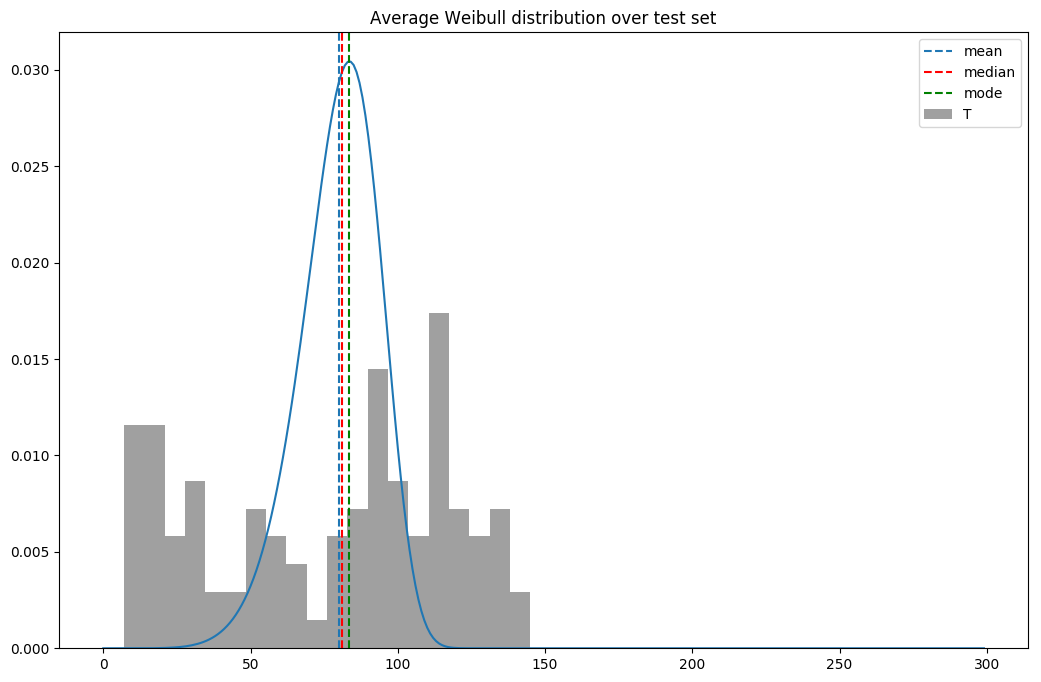

In [63]:
import math

t=np.arange(0,300)
alpha = test_results_df['alpha'].mean()
beta = test_results_df['beta'].mean()

plt.plot(t, weibull_pdf(alpha,beta, t))
mu = weibull_mean(alpha, beta)
median =weibull_median(alpha, beta)
mode = weibull_mode(alpha, beta)
plt.axvline(mu, ls='--', label='mean')
plt.axvline(median, ls='--', color='red', label='median')
plt.axvline(mode, ls='--', color='green', label='mode')
n, bins, patches = plt.hist(test_results_df['T'], 20, normed=1, facecolor='grey', alpha=0.75, label='T')
plt.legend()

plt.gcf().set_size_inches(12.5, 8)
plt.title('Average Weibull distribution over test set')
print('alpha', alpha, 'beta', beta)

In [0]:
def plot_weibull_predictions(results_df):

    fig, axarr = plt.subplots(3, figsize=(20,30))

    t=np.arange(0,400)
#palette=sns.color_palette("Blues")
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
#sns.palplot(sns.color_palette(flatui))

#    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    palette = sns.color_palette(flatui, results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))

    for i, row in enumerate(results_df.iterrows()):
        alpha=row[1]['alpha']
        beta = row[1]['beta']
        T = row[1]['T']
        label = 'a={} b={}'.format(alpha, beta)

        color = color_dict[i]
        ax= axarr[0]
        mode = weibull_mode(alpha, beta)
        y_max = weibull_pdf(alpha, beta, mode)    

        ax.plot(t, weibull_pdf(alpha, beta, t), color=color, label=label)
        ax.scatter(T, weibull_pdf(alpha,beta, T), color=color, s=100)
        ax.vlines(mode, ymin=0, ymax=y_max, colors=color, linestyles='--')

        ax.set_title('Weibull distributions')
    
    ax=axarr[1]
    
    median_predictions = weibull_median(results_df['alpha'], results_df['beta'])
    mean_predictions = results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
    mode_predictions = weibull_mode(results_df['alpha'], results_df['beta'])
#     x = results_df['time']
    
#     ax.scatter(x, results_df['T'], label='survival_time', color='black')

#     ax.scatter(results_df['T'], median_predictions, label='median_prediction')
#     ax.scatter(results_df['T'], mean_predictions, label='mean_prediction')
    ax.scatter(results_df['T'], mode_predictions, label='m_prediction')
    ax.set_title('MAP prediction Vs. true')
    

    ax.legend()
    
    ax=axarr[2]
    sns.distplot(results_df['T'] - mode_predictions, ax=ax)
    ax.set_title('Error')

#     ax.plot(x, results_df['alpha'], label='alpha')
#     ax.legend()
    
#     ax = axarr[3]
#     ax.plot(x, results_df['beta'], label='beta')
#     ax.legend()
    
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     fig.suptitle(title)
    plt.show()

In [65]:
train_orig.describe()

,unit_number,time,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [66]:
test_results_df.head()
test_results_df.loc[test_results_df['unit_number'] == 1]


,T,E,alpha,beta,predicted_mode,unit_number
0,112.0,1.0,192.699509,6.185493,187.283423,1


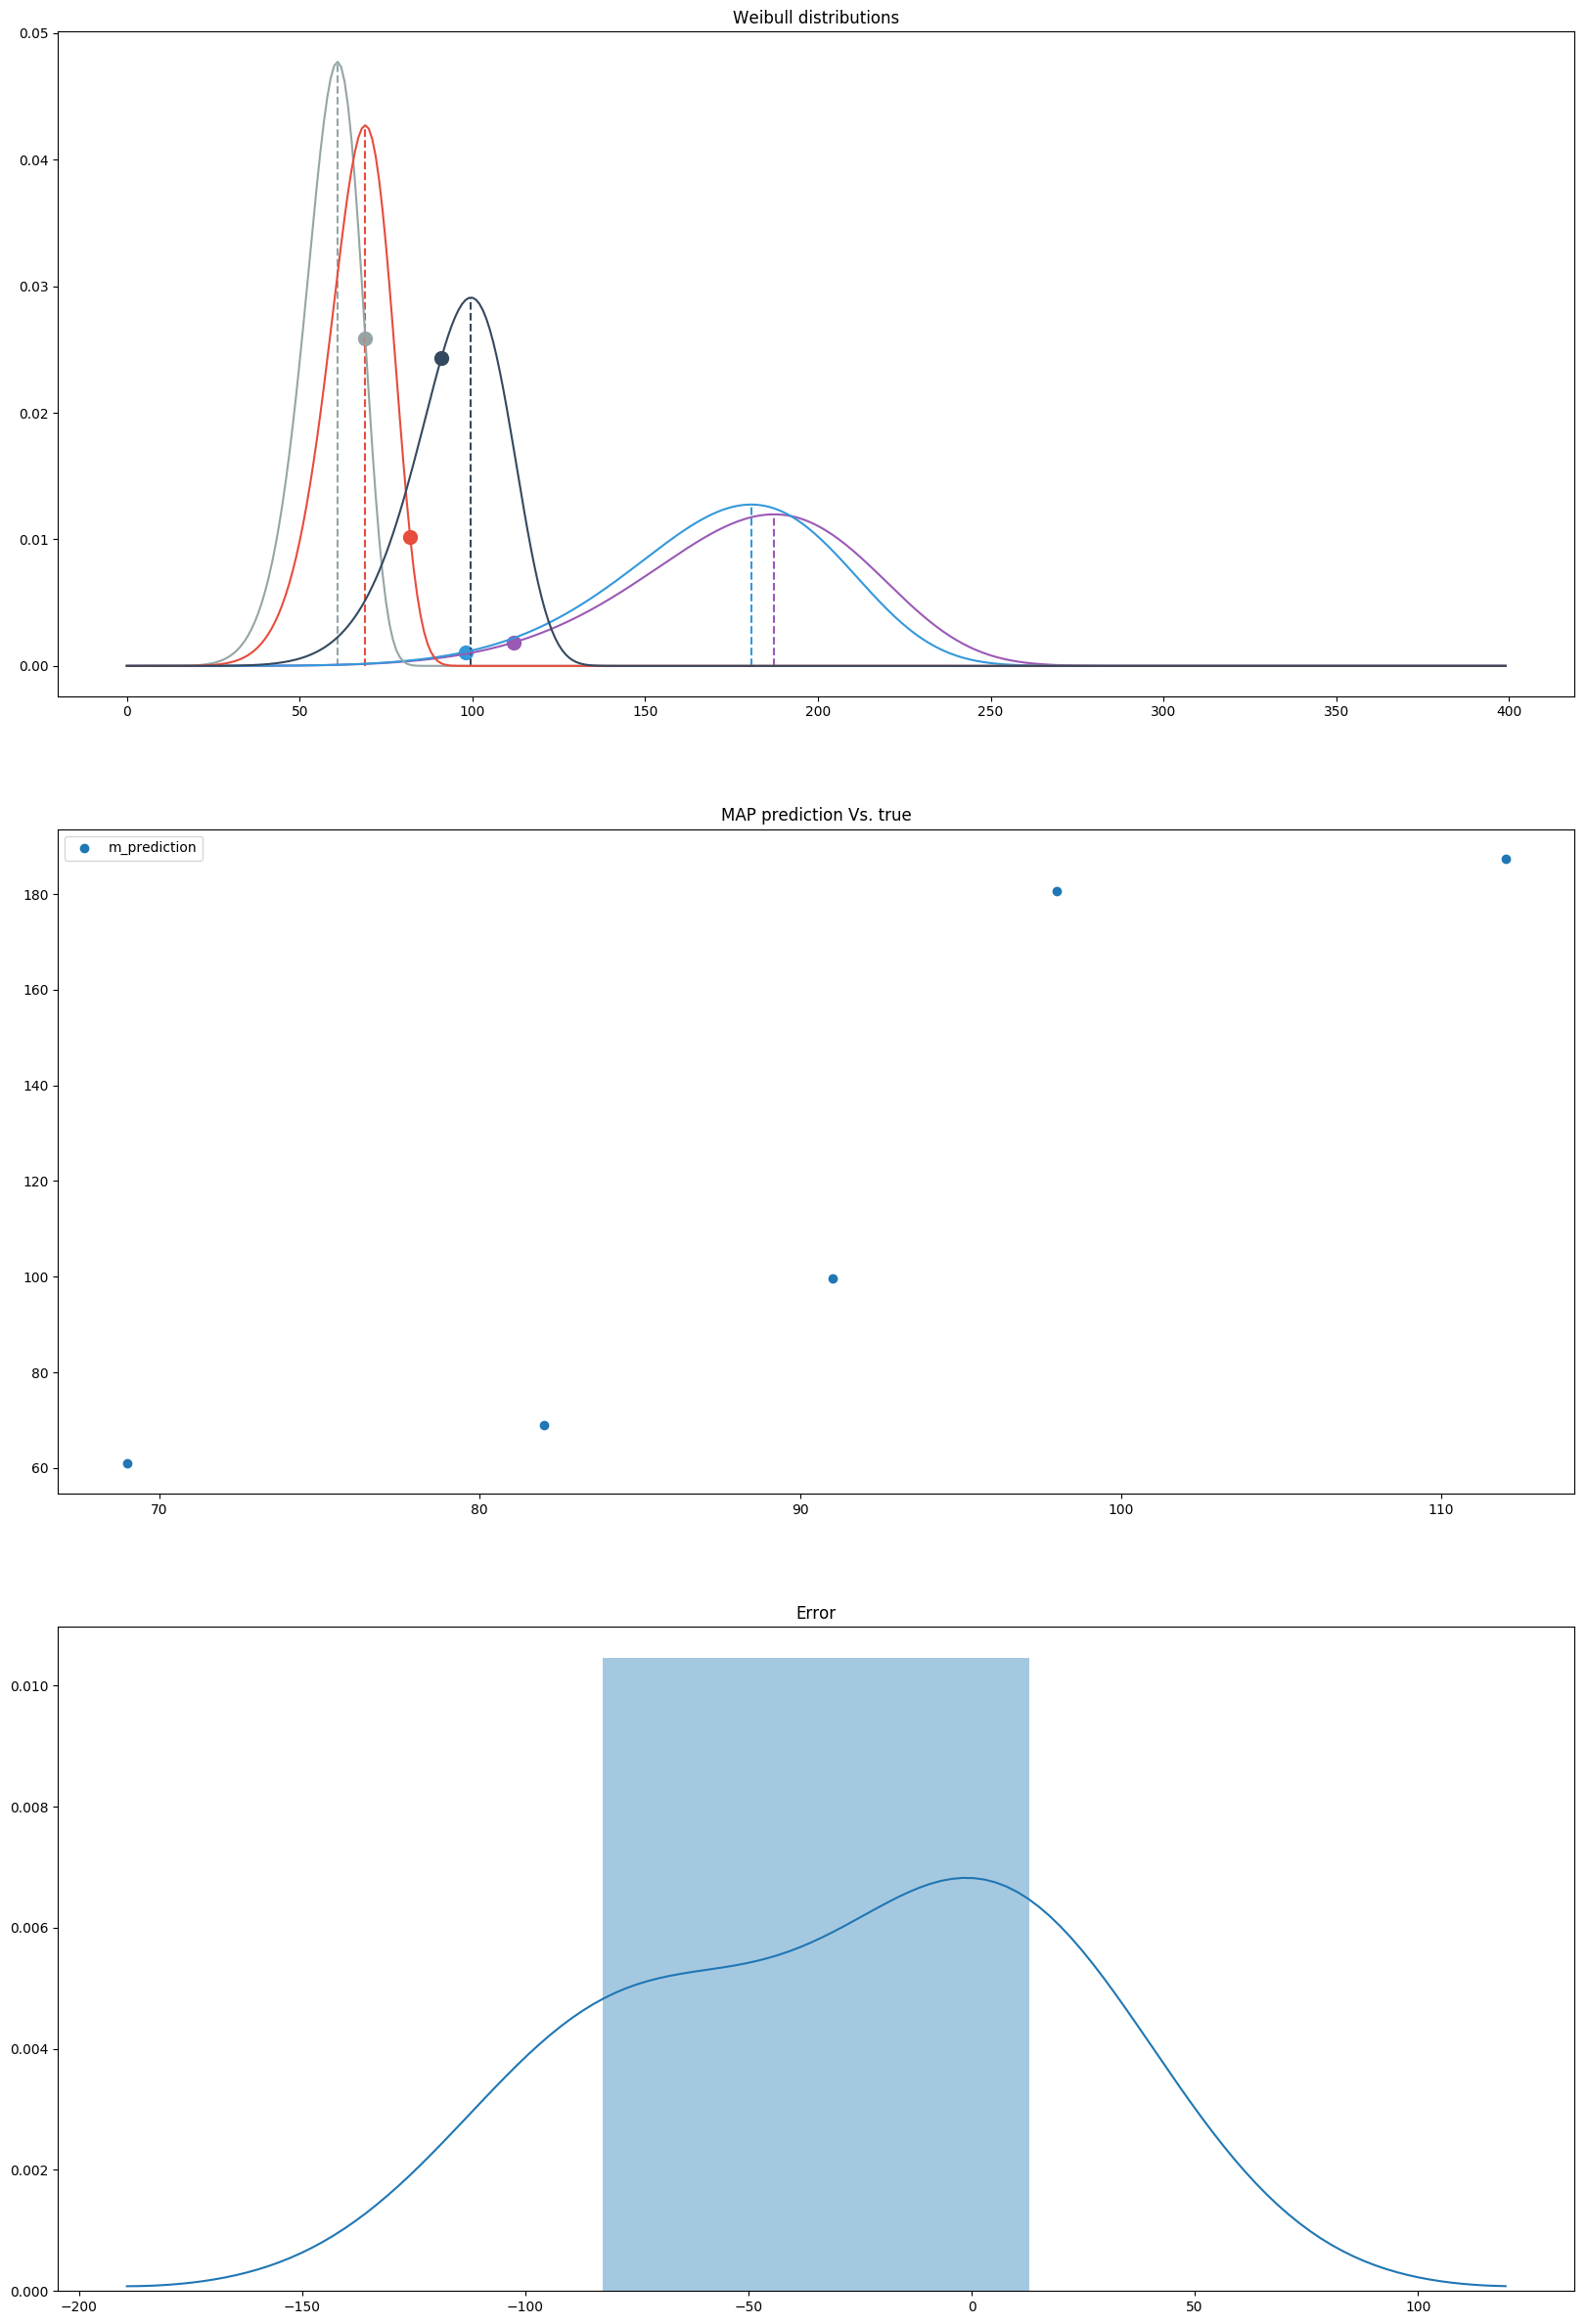

In [67]:
import seaborn as sns

plot_weibull_predictions(results_df=test_results_df.head(5))

In [0]:
test_results_df['predicted_mu'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
test_results_df['predicted_median'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)
test_results_df['predicted_mode'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)

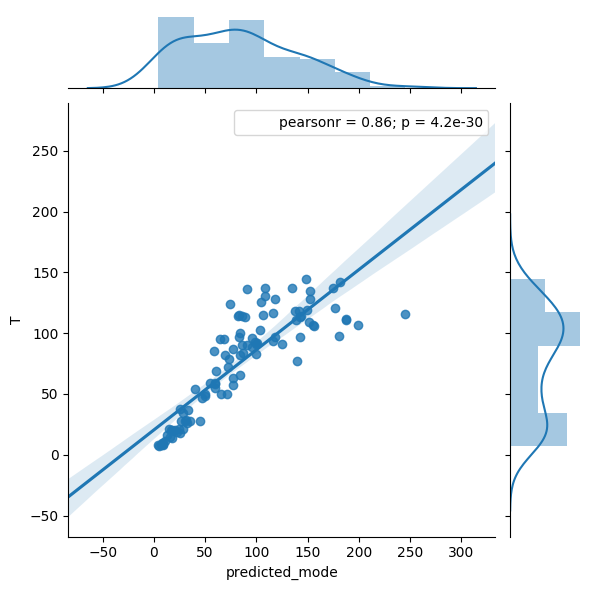

In [69]:
import seaborn as sns
sns.jointplot(data=test_results_df, y='T', x='predicted_mode',kind="reg")

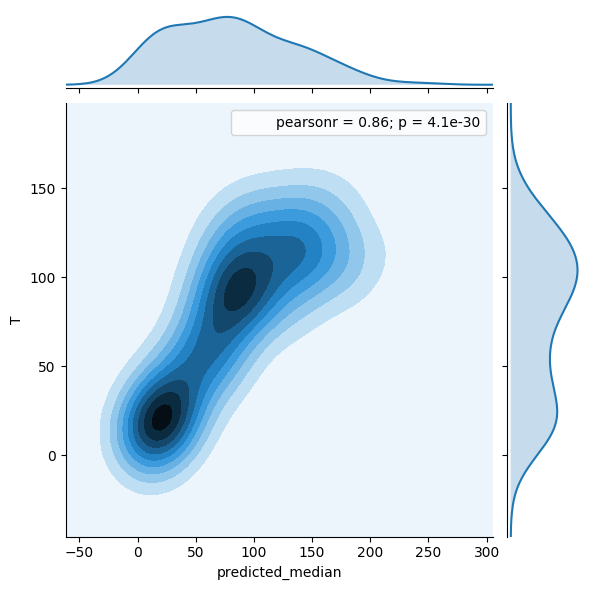

In [70]:
sns.jointplot(data=test_results_df, y='T', x='predicted_median',kind="kde" )

In [71]:
test_results_df['error'] = test_results_df['T']-test_results_df['predicted_median']
test_results_df['error'].describe()

count    100.000000
mean      -5.634740
std       27.280954
min     -122.425045
25%      -15.684490
50%       -0.054419
75%        6.326571
max       51.994078
Name: error, dtype: float64

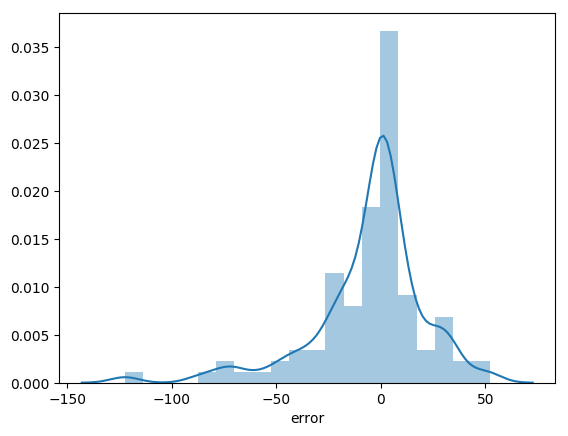

In [72]:
sns.distplot(test_results_df['error'], bins=20)

**Training evaluation**

In [73]:
test_y.shape


(100, 2)

In [74]:
train_y.shape


(20631, 2)

In [0]:
train_predict=model.predict(train_x)


In [0]:
train_predict = np.resize(train_predict, (20631, 2))
train_result = np.concatenate((train_y, train_predict), axis=1)

In [77]:
train_predict.shape


(20631, 2)

In [0]:
train_results_df = pd.DataFrame(train_result, columns=['T', 'E', 'alpha', 'beta'])


In [0]:
train_results_df[['unit_number', 'time']] = train_orig[['unit_number', 'time']]


In [80]:
train_results_df['unit_number'].nunique()


100

In [81]:
train_results_df.shape


(20631, 6)

In [82]:
train_results_df.groupby('unit_number')['beta'].describe()


,count,mean,std,min,25%,50%,75%,max
unit_number,,,,,,,,
1,192.0,6.693203,1.360346,1.607210,6.002714,6.944522,7.783861,8.191685
2,287.0,6.379580,1.440984,1.596275,5.303325,6.760489,7.563784,8.161388
3,179.0,6.947220,1.405176,1.597854,6.194097,7.581904,8.038442,8.203853
4,189.0,7.002237,1.552623,1.594104,6.413387,7.773263,8.072483,8.224563
5,269.0,6.622021,1.260022,1.595420,6.080605,6.744949,7.491094,8.160799
6,188.0,6.641344,1.494406,1.596923,6.253096,6.937093,7.719495,8.197814
7,259.0,6.699034,1.336238,1.596328,5.998034,6.832087,7.814551,8.200656
8,150.0,6.754790,1.501185,1.596681,6.128844,7.374684,7.824245,8.033925
9,201.0,6.964249,1.296896,1.596223,6.275818,7.344907,7.948986,8.172714


In [0]:
#for unit_number, grp in train_results_df.groupby('unit_number'):
    #plot_weibull_predictions(grp)
 #       plot_weibull_predictions(grp, unit_number)

In [0]:
train_results_df['predicted_mu'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
train_results_df['predicted_median'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)

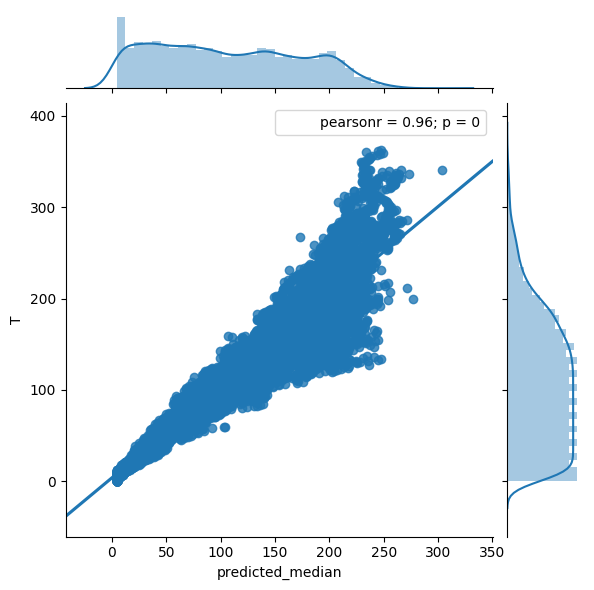

In [85]:
sns.jointplot(data=train_results_df, y='T', x='predicted_median',kind="reg")

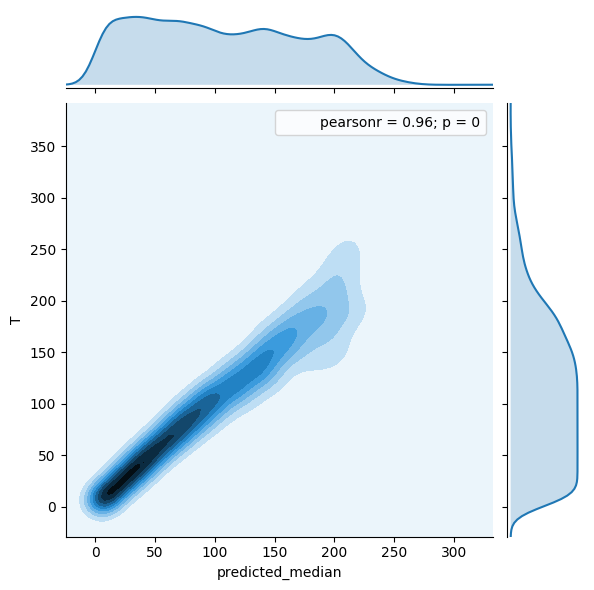

In [86]:
sns.jointplot(data=train_results_df, y='T', x='predicted_median',kind="kde" )


In [87]:
train_results_df['error'] = train_results_df['T']-train_results_df['predicted_median']
train_results_df['error'].describe()


count    20631.000000
mean         2.804143
std         19.650904
min       -113.925722
25%         -3.121025
50%          3.123739
75%         10.632945
max        125.891203
Name: error, dtype: float64

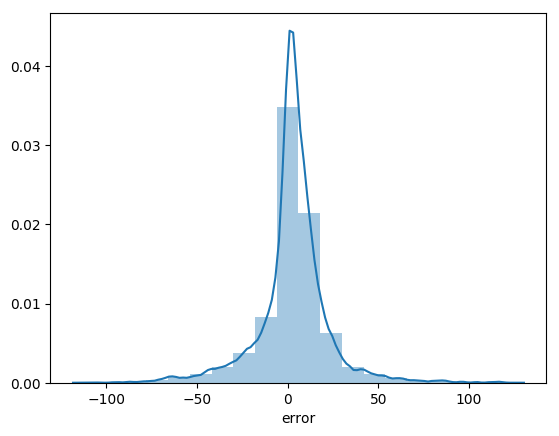

In [88]:
sns.distplot(train_results_df['error'], bins=20)
